# Code for Assignment 1 - Supervised learning (Diabetes data)

This notebook includes analyses for 5 different classification algorithms for the Diabetes dataset

Classification Algorithms: Decision Tree, Neural Network, Boosting, SVM, KNN

# Import Data

In [1]:
import pandas as pd
import timeit
import numpy as np
from sklearn.model_selection import learning_curve,  ShuffleSplit, validation_curve, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
df = pd.read_csv("./data/diabetes.csv")

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
# Split into train-test sets 

y = np.ravel(df[["Outcome"]])
x = df.drop(["Outcome"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=8451)

## Helper Functions

In [6]:
def classifier_metrics(estimator, x_train, x_test, y_train, y_test):
    
    start = timeit.default_timer()
    estimator.fit(x_train, y_train)
    end = timeit.default_timer()
    training_time = end - start
    
    start = timeit.default_timer()    
    y_pred = estimator.predict(x_test)
    end = timeit.default_timer()
    prediction_time = end - start
    
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)

    print("Metrics for Test Set")
    print("-------------------------------------------------------------")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}".format(prediction_time))
    print("F1 Score:  "+"{:.3f}".format(f1))
    print("Accuracy:  "+"{:.3f}".format(accuracy))

In [7]:
# stolen from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
#        shuffle=True
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# 1. Decision Tree


Hyperparameters:

    - criterion: gini, entropy, logloss
    - max_depth: 1-50

In [8]:
from sklearn.tree import DecisionTreeClassifier

### Initial decision tree accuracy with no tuning

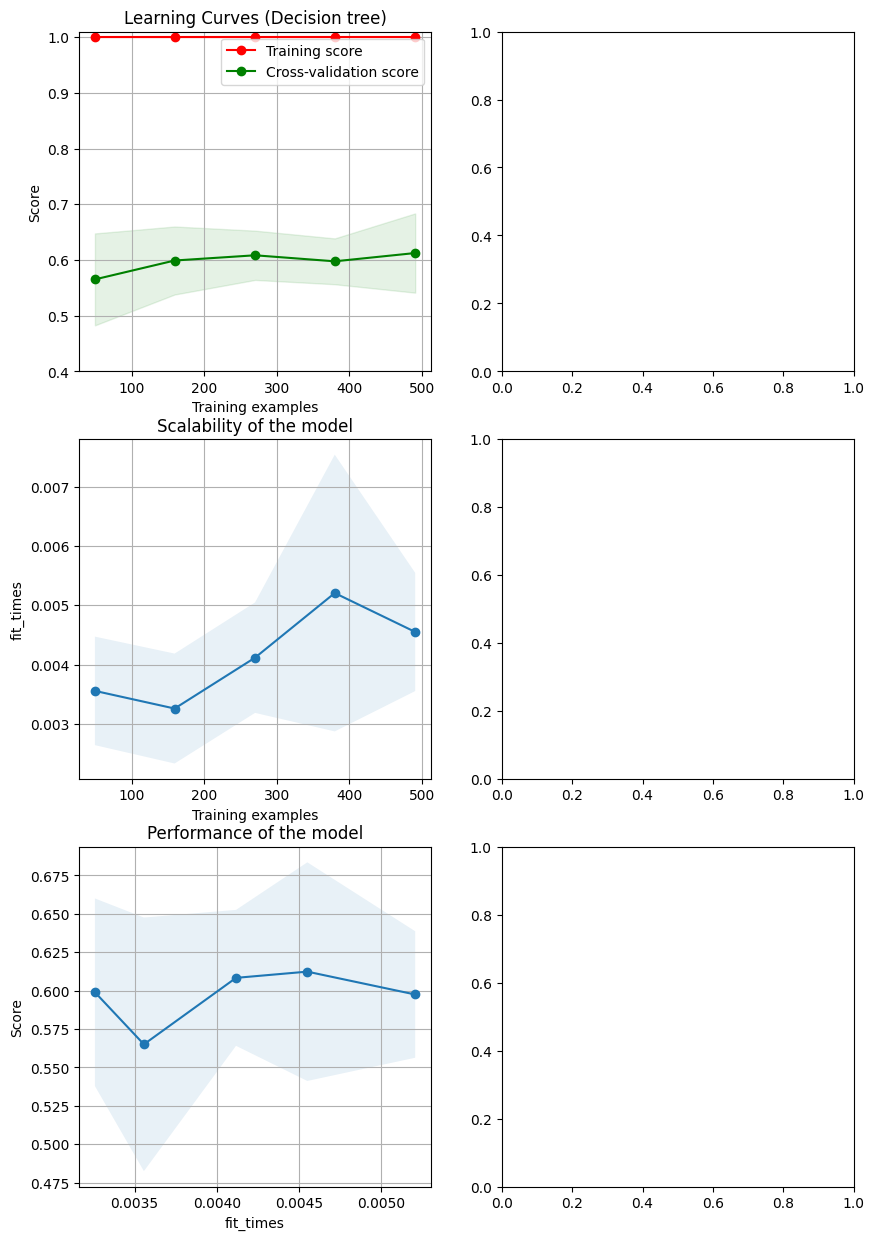

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Decision tree)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = DecisionTreeClassifier(random_state=8451)
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.4, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [10]:
#decision tree on Diabetes data initial scoring

estimator = DecisionTreeClassifier(random_state=8451)
cv_results = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
print(f"Initial fit time of decision tree is {cv_results['fit_time'].mean()}")
print(f"Initial score time of decision tree is {cv_results['score_time'].mean()}")
print(f"Initial f1 score of decision tree on cross validation {cv_results['test_f1'].mean()}")
print(f"Initial accuracy of decision tree on cross validation {cv_results['test_accuracy'].mean() * 100}%")

Initial fit time of decision tree is 0.004787874221801758
Initial score time of decision tree is 0.002248525619506836
Initial f1 score of decision tree on cross validation 0.6238903350030671
Initial accuracy of decision tree on cross validation 73.4519525523124%


In [11]:
classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.00503
Model Prediction Time (s): 0.00166
F1 Score:  0.562
Accuracy:  0.727


### Hyperparameter tuning

In [69]:
%%time

# validation curves for max_depth for both gini and entropy criterion
max_depth = [i for i in range(1,50)]
min_samples_leaf = [i for i in range(1,50)]

# accuracy scores
acc_gini_max_depth = []
acc_entropy_max_depth = []
acc_gini_min_leaf = []
acc_entropy_min_leaf = []

# f1 scores
f1_gini_max_depth = []
f1_entropy_max_depth = []
f1_gini_min_leaf = []
f1_entropy_min_leaf = []



for i in range(1,50):
    
    # max_depth
    estimator = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_gini_max_depth.append(score["test_accuracy"].mean())
    f1_gini_max_depth.append(score["test_f1"].mean())

    estimator = DecisionTreeClassifier(criterion="entropy", max_depth=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_entropy_max_depth.append(score["test_accuracy"].mean())
    f1_entropy_max_depth.append(score["test_f1"].mean())
    
    # min_samples_leaf
    estimator = DecisionTreeClassifier(criterion="gini", min_samples_leaf=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_gini_min_leaf.append(score["test_accuracy"].mean())
    f1_gini_min_leaf.append(score["test_f1"].mean())

    estimator = DecisionTreeClassifier(criterion="entropy", min_samples_leaf=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_entropy_min_leaf.append(score["test_accuracy"].mean())
    f1_entropy_min_leaf.append(score["test_f1"].mean())
    

scores = pd.DataFrame(
    {
        "acc_gini_max_depth":pd.Series(acc_gini_max_depth),      
        "acc_entropy_max_depth":pd.Series(acc_entropy_max_depth),      
        "f1_gini_max_depth":pd.Series(f1_gini_max_depth),      
        "f1_entropy_max_depth":pd.Series(f1_entropy_max_depth),      
        "acc_gini_min_leaf":pd.Series(acc_gini_min_leaf),      
        "acc_entropy_min_leaf":pd.Series(acc_entropy_min_leaf),      
        "f1_gini_min_leaf":pd.Series(f1_gini_min_leaf),      
        "f1_entropy_min_leaf":pd.Series(f1_entropy_min_leaf),
        "max_depth":pd.Series(max_depth),
        "min_samples_leaf":pd.Series(min_samples_leaf),
    }
)

CPU times: user 5.4 s, sys: 32.9 ms, total: 5.44 s
Wall time: 5.45 s


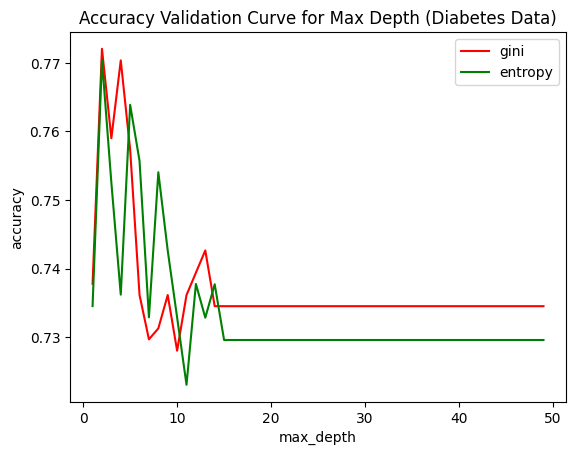

In [13]:
plt.plot("max_depth","acc_gini_max_depth", color="r", data=scores, label="gini")
plt.plot("max_depth","acc_entropy_max_depth", color="g", data=scores, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for Max Depth (Diabetes Data)")
plt.legend()

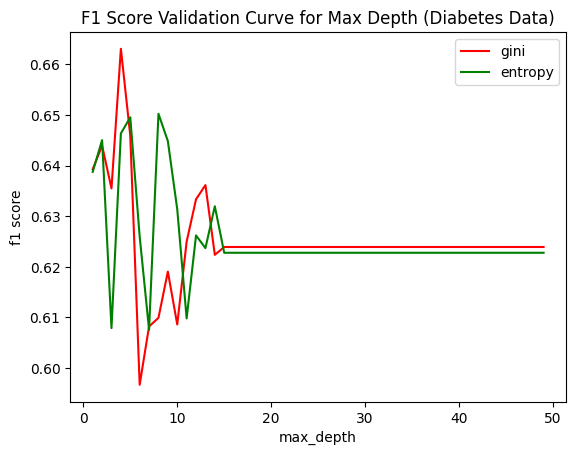

In [14]:
plt.plot("max_depth","f1_gini_max_depth", color="r", data=scores, label="gini")
plt.plot("max_depth","f1_entropy_max_depth", color="g", data=scores, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for Max Depth (Diabetes Data)")
plt.legend()

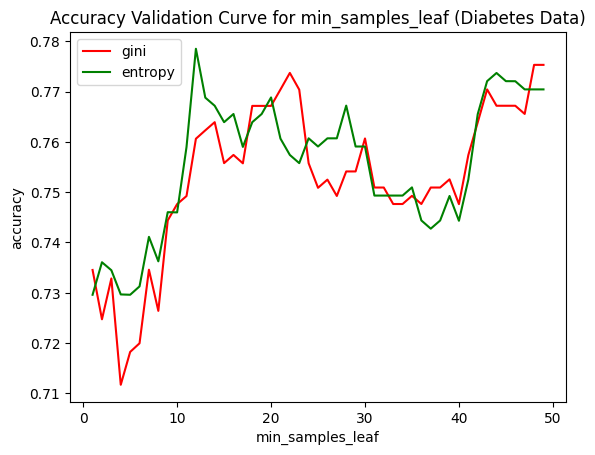

In [15]:
plt.plot("min_samples_leaf","acc_gini_min_leaf", color="r", data=scores, label="gini")
plt.plot("min_samples_leaf","acc_entropy_min_leaf", color="g", data=scores, label="entropy")
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for min_samples_leaf (Diabetes Data)")
plt.legend()

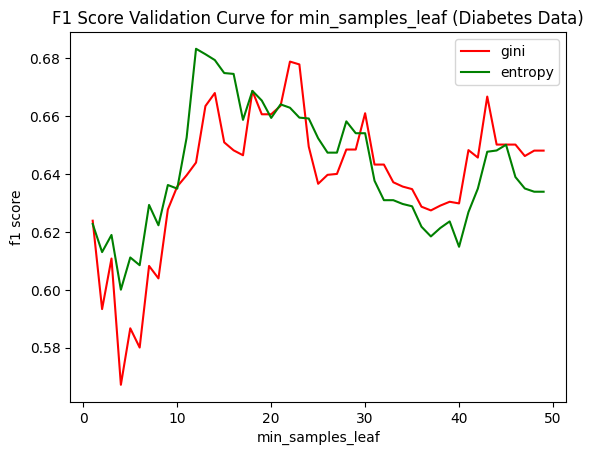

In [70]:
plt.plot("min_samples_leaf","f1_gini_min_leaf", color="r", data=scores, label="gini")
plt.plot("min_samples_leaf","f1_entropy_min_leaf", color="g", data=scores, label="entropy")
plt.xlabel("min_samples_leaf")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for min_samples_leaf (Diabetes Data)")
plt.legend()

In [72]:
%%time

# Grid search for
#    max_depth
#    criterion
params = {'criterion':["gini", "entropy"], 'max_depth':np.arange(1,50), 'min_samples_leaf':np.arange(1,50)}
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

decision_tree = GridSearchCV(estimator = DecisionTreeClassifier(random_state=8451), param_grid=params, scoring="f1", cv=cv)
decision_tree.fit(x_train, y_train)
max_depth = int(decision_tree.best_params_["max_depth"])
criterion = decision_tree.best_params_["criterion"]
min_samples_leaf = int(decision_tree.best_params_["min_samples_leaf"])
print(f"Best max_depth from Hyperparameter tuning: {max_depth}")
print(f"Best criterion from Hyperparameter tuning: {criterion}")
print(f"Best min_samples_leaf from Hyperparameter tuning: {min_samples_leaf}")

Best max_depth from Hyperparameter tuning: 5
Best criterion from Hyperparameter tuning: entropy
Best min_samples_leaf from Hyperparameter tuning: 30
CPU times: user 4min 3s, sys: 1.56 s, total: 4min 5s
Wall time: 4min 6s


### Retrain Decision tree with optimal params

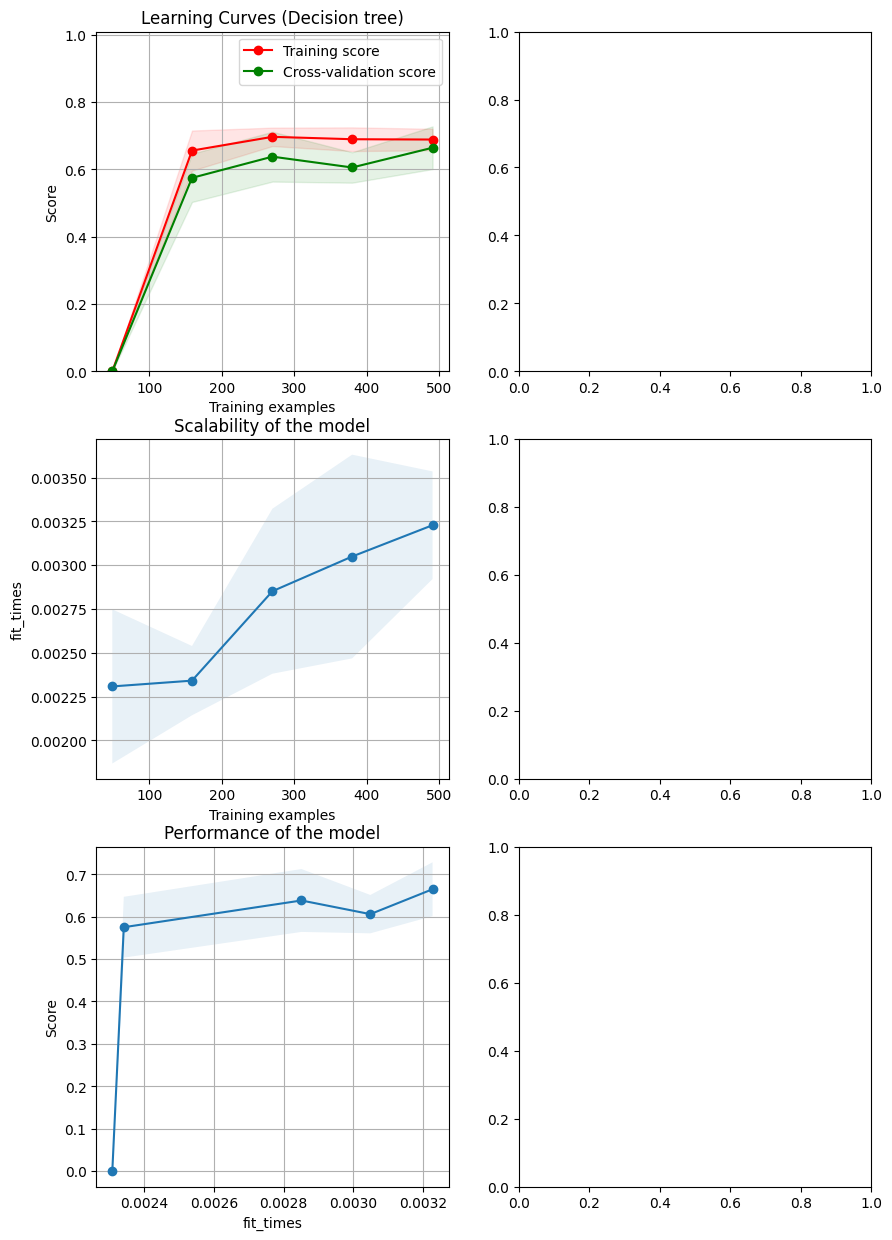

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Decision tree)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = DecisionTreeClassifier(
    random_state=8451, 
    criterion=criterion, 
    min_samples_leaf=min_samples_leaf, 
    max_depth=max_depth
)

plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.0, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [74]:
estimator = DecisionTreeClassifier(
    random_state=8451, 
    criterion=criterion, 
    min_samples_leaf=min_samples_leaf, 
    max_depth=max_depth
)

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.00607
Model Prediction Time (s): 0.00220
F1 Score:  0.535
Accuracy:  0.740


# 2. Boosting


Hyperparameters:

    - n_estimators
    - learning_rate

In [20]:
from sklearn.ensemble import AdaBoostClassifier

### Initial Boosting metrics with no tuning

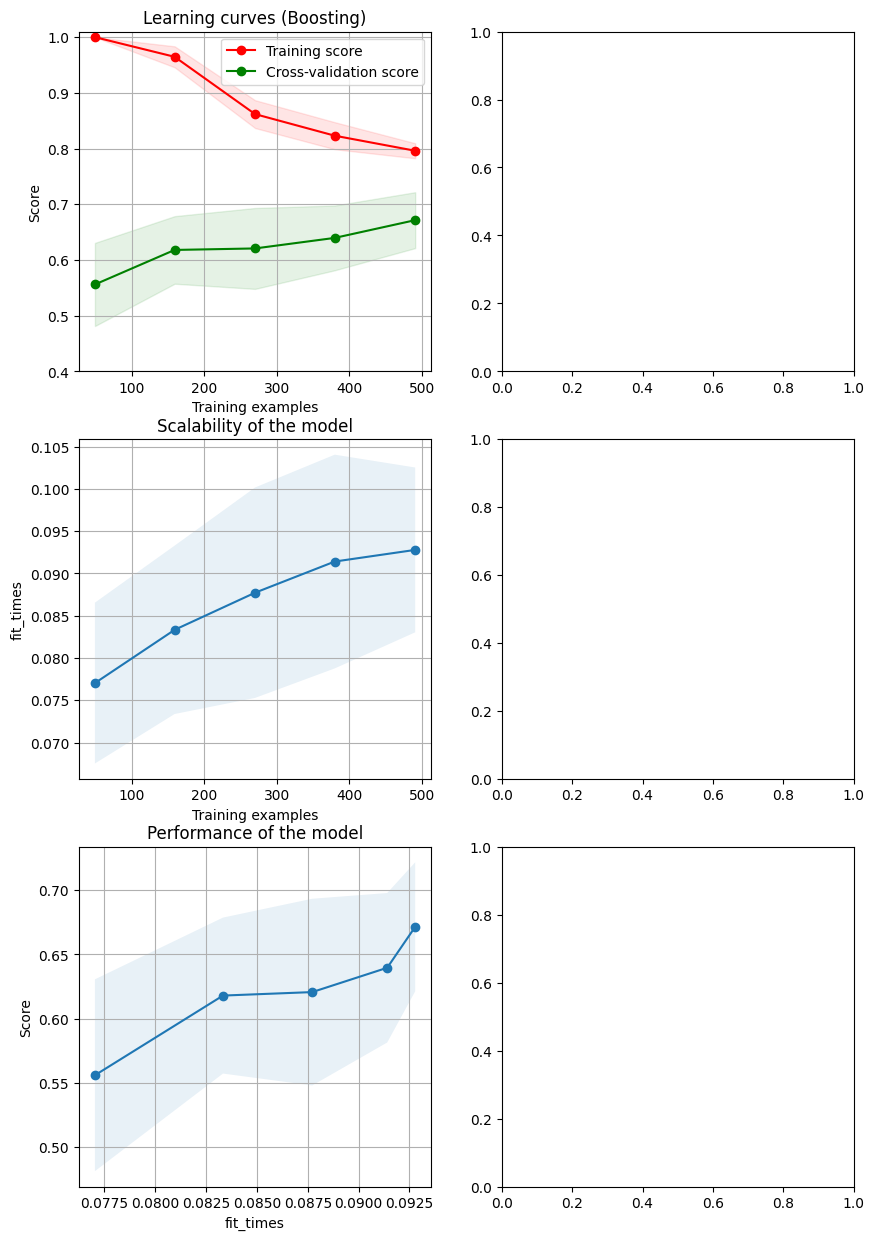

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning curves (Boosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = AdaBoostClassifier(random_state=8451)
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.4, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [22]:
#decision tree on Diabetes data initial scoring

estimator = AdaBoostClassifier(random_state=8451)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)
cv_results = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"], cv=cv)
print(f"Initial fit time of boosting is {cv_results['fit_time'].mean()}")
print(f"Initial score time of boosting is {cv_results['score_time'].mean()}")
print(f"Initial f1 score of boosting on cross validation {cv_results['test_f1'].mean()}")
print(f"Initial accuracy of boosting on cross validation {cv_results['test_accuracy'].mean() * 100}%")

Initial fit time of boosting is 0.07632303237915039
Initial score time of boosting is 0.010559296607971192
Initial f1 score of boosting on cross validation 0.6713810825380696
Initial accuracy of boosting on cross validation 77.3170731707317%


In [23]:
classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.07992
Model Prediction Time (s): 0.00933
F1 Score:  0.462
Accuracy:  0.682


### Hyperparameter Tuning

In [24]:
%%time

# validation curves for max_depth for both gini and entropy criterion
n_estimators = list(np.arange(5,100,5))
max_depth = [i for i in range(1,5)]
learning_rate = list(np.linspace(.1,2,20))

# accuracy scores
acc_max_depth = []
acc_n_estimators = []
acc_learning_rate = []

# f1 scores
f1_max_depth = []
f1_n_estimators = []
f1_learning_rate = []

for i in max_depth:
    base = DecisionTreeClassifier(max_depth=i, random_state=8451)
    estimator = AdaBoostClassifier(base_estimator=base, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_max_depth.append(score["test_accuracy"].mean())
    f1_max_depth.append(score["test_f1"].mean())


for i in n_estimators:   
    estimator = AdaBoostClassifier(n_estimators=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_n_estimators.append(score["test_accuracy"].mean())
    f1_n_estimators.append(score["test_f1"].mean())
    
for i in learning_rate:   
    estimator = AdaBoostClassifier(learning_rate=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_learning_rate.append(score["test_accuracy"].mean())
    f1_learning_rate.append(score["test_f1"].mean())

max_depth_df = pd.DataFrame(
    {
        "acc_max_depth":pd.Series(acc_max_depth),      
        "f1_max_depth":pd.Series(f1_max_depth),           
        "max_depth":pd.Series(max_depth),
    }
)

n_estimators_df = pd.DataFrame(
    {
        "acc_n_estimators":pd.Series(acc_n_estimators),      
        "f1_n_estimators":pd.Series(f1_n_estimators),
        "n_estimators":pd.Series(n_estimators),
    }
)

learning_rate_df = pd.DataFrame(
    {
        "acc_learning_rate":pd.Series(acc_learning_rate),      
        "f1_learning_rate":pd.Series(f1_learning_rate),
        "learning_rate":pd.Series(learning_rate),
    }
)


CPU times: user 19.3 s, sys: 151 ms, total: 19.4 s
Wall time: 19.6 s


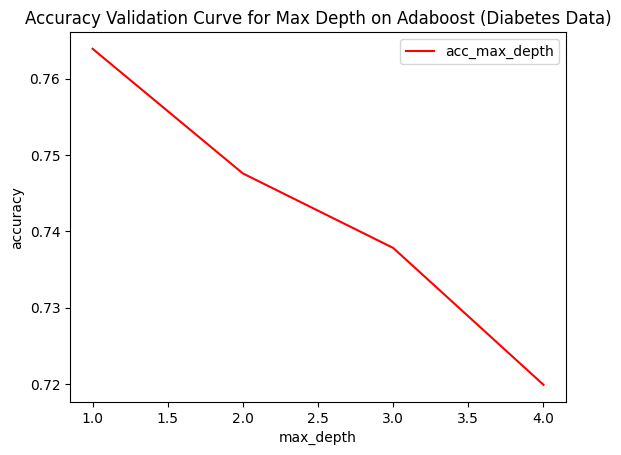

In [25]:
plt.plot("max_depth","acc_max_depth", color="r", data=max_depth_df)
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for Max Depth on Adaboost (Diabetes Data)")
plt.legend()

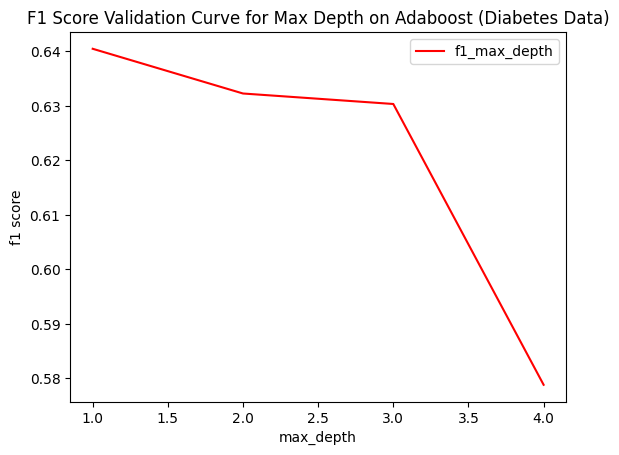

In [26]:
plt.plot("max_depth","f1_max_depth", color="r", data=max_depth_df)
plt.xlabel("max_depth")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for Max Depth on Adaboost (Diabetes Data)")
plt.legend()

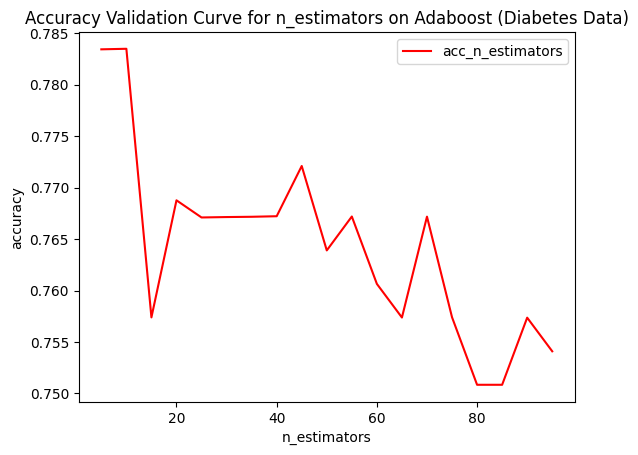

In [27]:
plt.plot("n_estimators","acc_n_estimators", color="r", data=n_estimators_df)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for n_estimators on Adaboost (Diabetes Data)")
plt.legend()

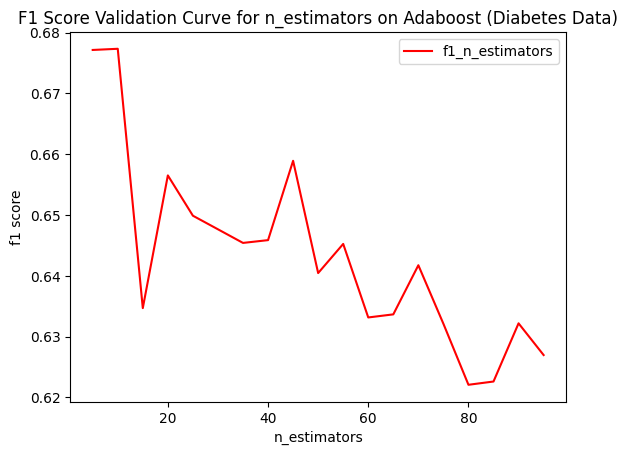

In [28]:
plt.plot("n_estimators","f1_n_estimators", color="r", data=n_estimators_df)
plt.xlabel("n_estimators")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for n_estimators on Adaboost (Diabetes Data)")
plt.legend()

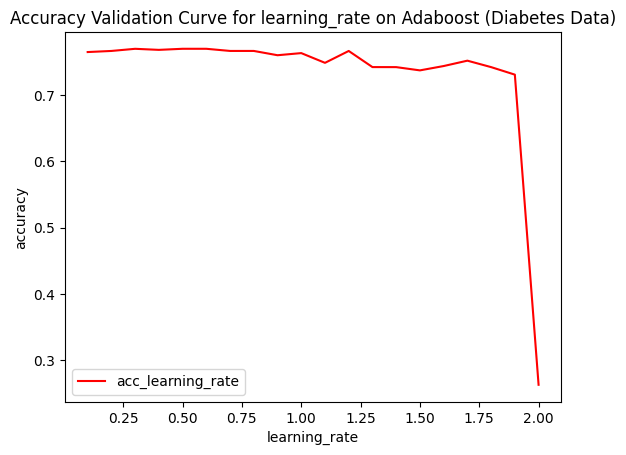

In [29]:
plt.plot("learning_rate","acc_learning_rate", color="r", data=learning_rate_df)
plt.xlabel("learning_rate")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for learning_rate on Adaboost (Diabetes Data)")
plt.legend()

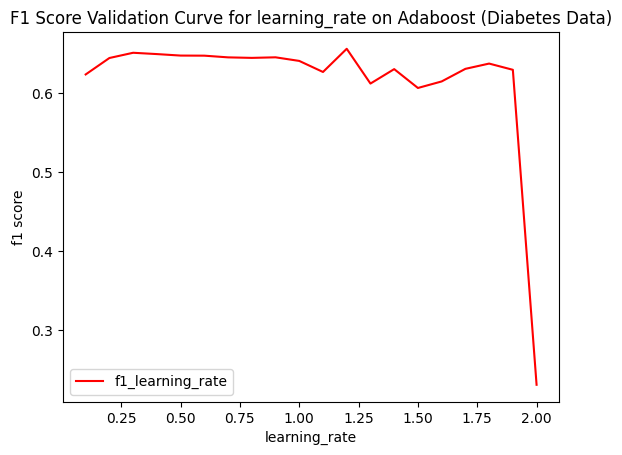

In [30]:
plt.plot("learning_rate","f1_learning_rate", color="r", data=learning_rate_df)
plt.xlabel("learning_rate")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for learning_rate on Adaboost (Diabetes Data)")
plt.legend()

In [76]:
%%time

# Grid search
params = {'learning_rate':list(np.linspace(.1, 1, 10)), 'n_estimators':list(np.arange(5, 75, 5))}
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

base = DecisionTreeClassifier(random_state=8451)
estimator = AdaBoostClassifier(base_estimator=base, random_state=8451)
boosted_tree = GridSearchCV(estimator = estimator, param_grid=params, scoring="f1", cv=cv)
boosted_tree.fit(x_train, y_train)


learning_rate = float(boosted_tree.best_params_["learning_rate"])
n_estimators = int(boosted_tree.best_params_["n_estimators"])
print(f"Best learning_rate from Hyperparameter tuning: {learning_rate}")
print(f"Best n_estimators from Hyperparameter tuning: {n_estimators}")

Best learning_rate from Hyperparameter tuning: 0.1
Best n_estimators from Hyperparameter tuning: 5
CPU times: user 10.2 s, sys: 85.2 ms, total: 10.3 s
Wall time: 10.4 s


### Retrain Boosted trees with optimal params

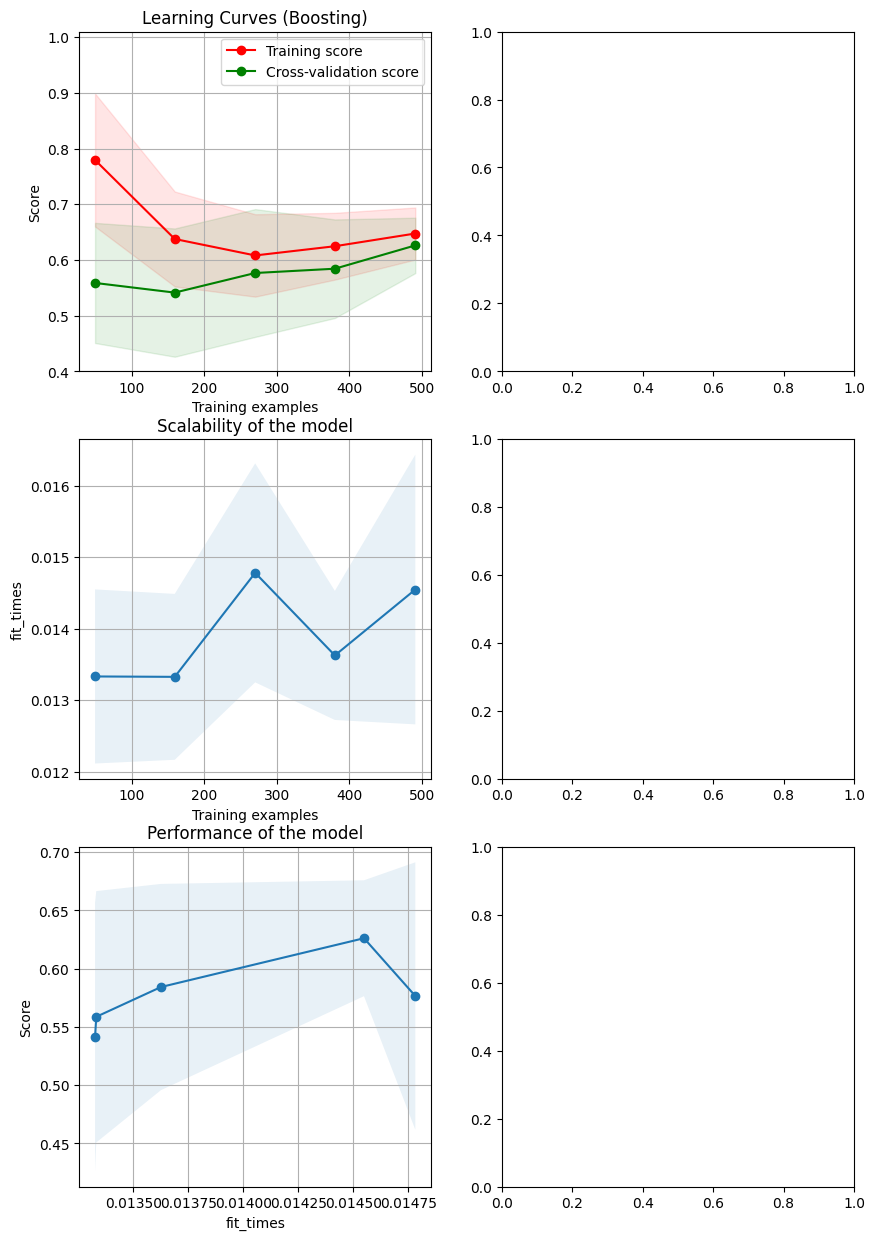

In [77]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Boosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

base = DecisionTreeClassifier(max_depth=1, random_state=8451)

estimator = AdaBoostClassifier(
    base_estimator=base,
    random_state=8451, 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
)

plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.4, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [78]:
base = DecisionTreeClassifier(max_depth=1, random_state=8451)

estimator = AdaBoostClassifier(
    base_estimator=base,
    random_state=8451, 
    learning_rate=learning_rate, 
    n_estimators=n_estimators, 
)

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.01576
Model Prediction Time (s): 0.00226
F1 Score:  0.516
Accuracy:  0.708


# 3. Neural Network

Hyperparameters:

    * Hidden layers
    * 

In [37]:
from sklearn.neural_network import MLPClassifier

### Initial NN with no tuning

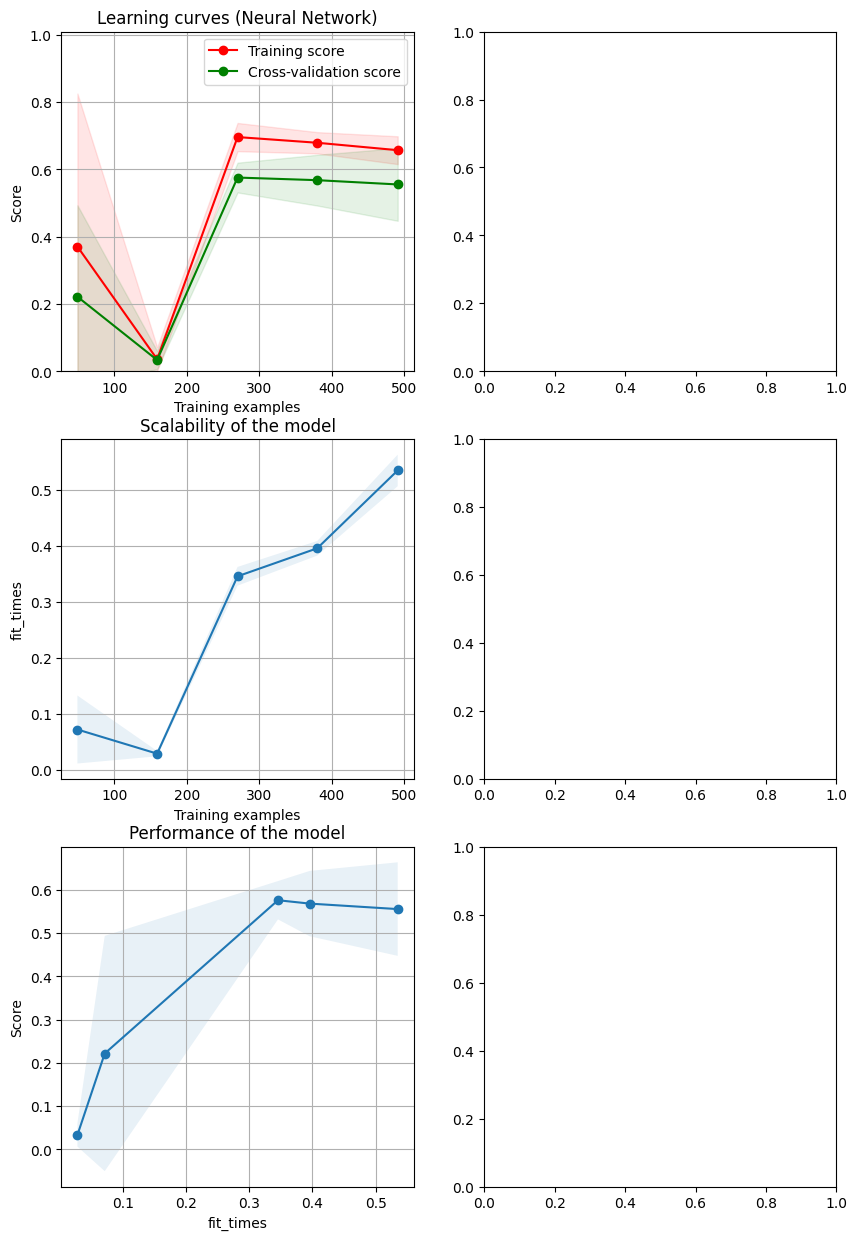

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning curves (Neural Network)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = MLPClassifier(random_state=8451)
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [39]:
estimator = MLPClassifier(random_state=8451)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)
cv_results = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"], cv=cv)
print(f"Initial fit time of boosting is {cv_results['fit_time'].mean()}")
print(f"Initial score time of boosting is {cv_results['score_time'].mean()}")
print(f"Initial f1 score of boosting on cross validation {cv_results['test_f1'].mean()}")
print(f"Initial accuracy of boosting on cross validation {cv_results['test_accuracy'].mean() * 100}%")

Initial fit time of boosting is 0.3663045883178711
Initial score time of boosting is 0.0028408527374267577
Initial f1 score of boosting on cross validation 0.5555127875837795
Initial accuracy of boosting on cross validation 72.76422764227642%


In [40]:
estimator = MLPClassifier(random_state=8451)
classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.18464
Model Prediction Time (s): 0.00170
F1 Score:  0.511
Accuracy:  0.701


### HyperParameter Tuning


learning on dataset Diabetes
training: constant learning-rate
Training set score: 0.778502
Training set loss: 0.493203
training: constant with momentum
Training set score: 0.778502
Training set loss: 0.493203
training: constant with Nesterov's momentum
Training set score: 0.778502
Training set loss: 0.493203
training: inv-scaling with momentum
Training set score: 0.778502
Training set loss: 0.493203
training: inv-scaling with Nesterov's momentum
Training set score: 0.778502
Training set loss: 0.493203
training: adam
Training set score: 0.811075
Training set loss: 0.406725
training: sgd
Training set score: 0.786645
Training set loss: 0.451403


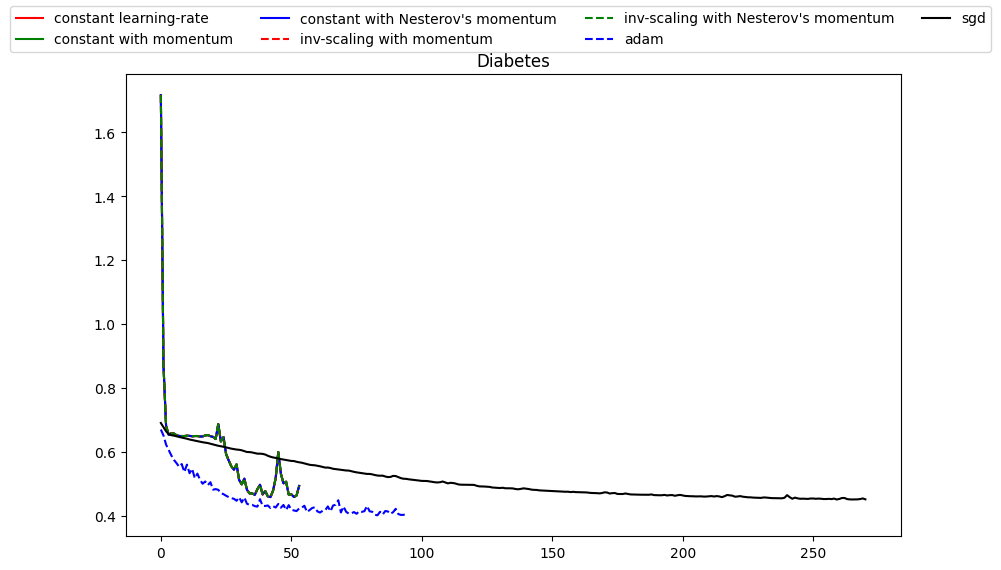

In [41]:
# stolen from https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "adam",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "adam",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "adam",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
#     {
#         "solver": "sgd",
#         "learning_rate": "invscaling",
#         "momentum": 0,
#         "learning_rate_init": 0.2,
#     },
    {
        "solver": "adam",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "adam",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
    {"solver": "sgd", "learning_rate_init": 0.01},
]

labels = [
    "constant learning-rate",
    "constant with momentum",
    "constant with Nesterov's momentum",
#     "inv-scaling learning-rate",
    "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum",
    "adam",
    "sgd",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)

    X = MinMaxScaler().fit_transform(X)
    mlps = []
    max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            mlp.fit(X, y)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(1, 1, figsize=(10, 6))
# # load / generate some toy datasets

plot_on_dataset(x_train, y_train, ax=axes, name="Diabetes")

fig.legend(axes.get_lines(), labels, ncol=4, loc="upper center")
plt.show()

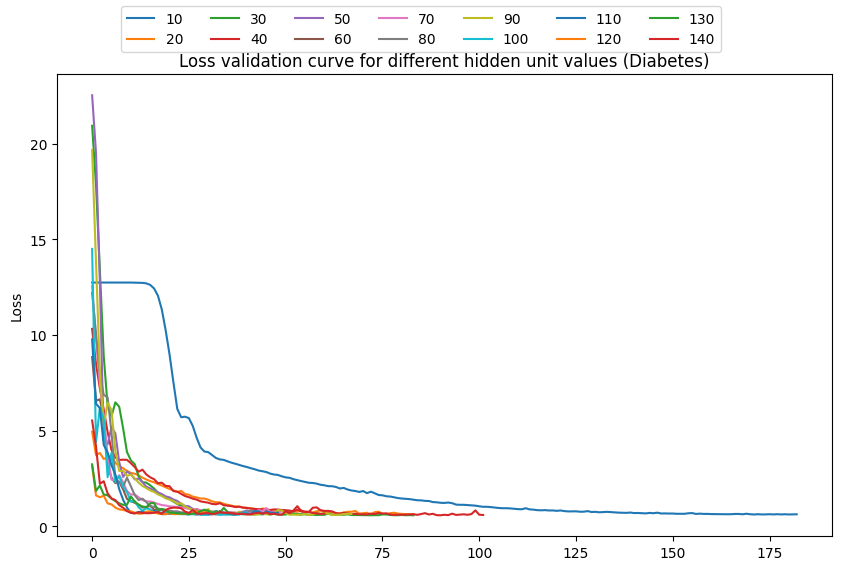

CPU times: user 23.9 s, sys: 4.19 s, total: 28.1 s
Wall time: 9.46 s


In [42]:
%%time

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
hidden_units = np.arange(10,150,10)

# accuracy scores
acc_hidden_units = []


# f1 scores
f1_hidden_units = []

for i in hidden_units:
    estimator = MLPClassifier(random_state=8451, hidden_layer_sizes=(i,), solver="adam", activation='identity')
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_hidden_units.append(score["test_accuracy"].mean())
    f1_hidden_units.append(score["test_f1"].mean())
    
    estimator.fit(x_train, y_train)
    axes.plot(estimator.loss_curve_, label=f'{i} units')
    

hidden_units_df_adam = pd.DataFrame(
    {
        "acc_hidden_units":pd.Series(acc_hidden_units),      
        "f1_hidden_units":pd.Series(f1_hidden_units),           
        "hidden_units":pd.Series(hidden_units),
    }
)
plt.ylabel('Loss')
plt.title("Loss validation curve for different hidden unit values (Diabetes)")
fig.legend(axes.get_lines(), hidden_units, ncol=7, loc="upper center")
plt.show()

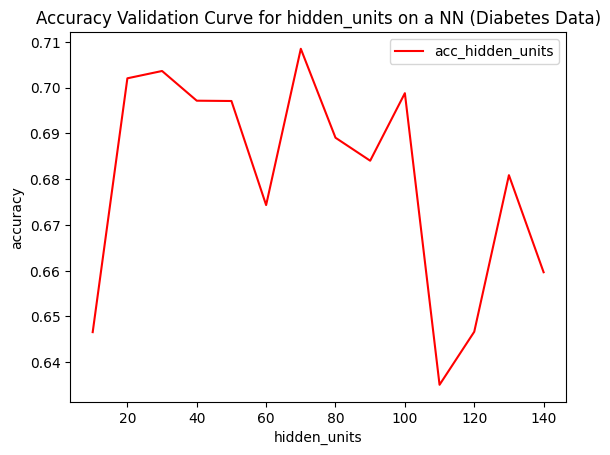

In [43]:
plt.plot("hidden_units","acc_hidden_units", color="r", data=hidden_units_df_adam)
plt.xlabel("hidden_units")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for hidden_units on a NN (Diabetes Data)")
plt.legend()

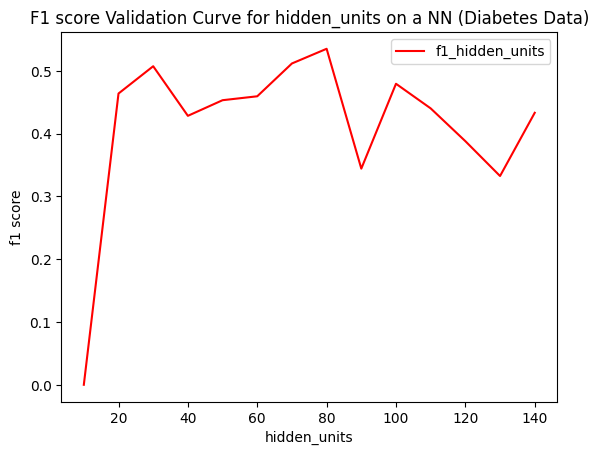

In [44]:
plt.plot("hidden_units","f1_hidden_units", color="r", data=hidden_units_df_adam)
plt.xlabel("hidden_units")
plt.ylabel("f1 score")
plt.title("F1 score Validation Curve for hidden_units on a NN (Diabetes Data)")
plt.legend()

In [45]:
%%time

# Grid search
hidden_units = np.arange(10,150,10)
learning_rates = [.005, 0.01, 0.05, .1]
params = {'learning_rate_init':learning_rates, 'hidden_layer_sizes':hidden_units}
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = MLPClassifier(random_state=8451, solver='lbfgs', activation='identity')
grid_search = GridSearchCV(estimator = estimator, param_grid=params, scoring="f1", cv=cv)
grid_search.fit(x_train, y_train)

learning_rate_init = float(grid_search.best_params_["learning_rate_init"])
hidden_layer_sizes = int(grid_search.best_params_["hidden_layer_sizes"])
print(f"Best learning_rate_init from Hyperparameter tuning: {learning_rate_init}")
print(f"Best hidden_layer_sizes from Hyperparameter tuning: {hidden_layer_sizes}")
print(f"Best score from Hyperparameter tuning: {grid_search.best_score_}")

Best learning_rate_init from Hyperparameter tuning: 0.005
Best hidden_layer_sizes from Hyperparameter tuning: 100
Best score from Hyperparameter tuning: 0.6579577693368319
CPU times: user 3min 34s, sys: 35 s, total: 4min 9s
Wall time: 1min 6s


In [46]:
estimator = MLPClassifier(
    random_state=8451, 
    solver='lbfgs', 
    activation='identity', 
    learning_rate_init=learning_rate_init,
    hidden_layer_sizes=hidden_layer_sizes,
)

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.18137
Model Prediction Time (s): 0.00152
F1 Score:  0.607
Accuracy:  0.773


### Retrain with optimal params

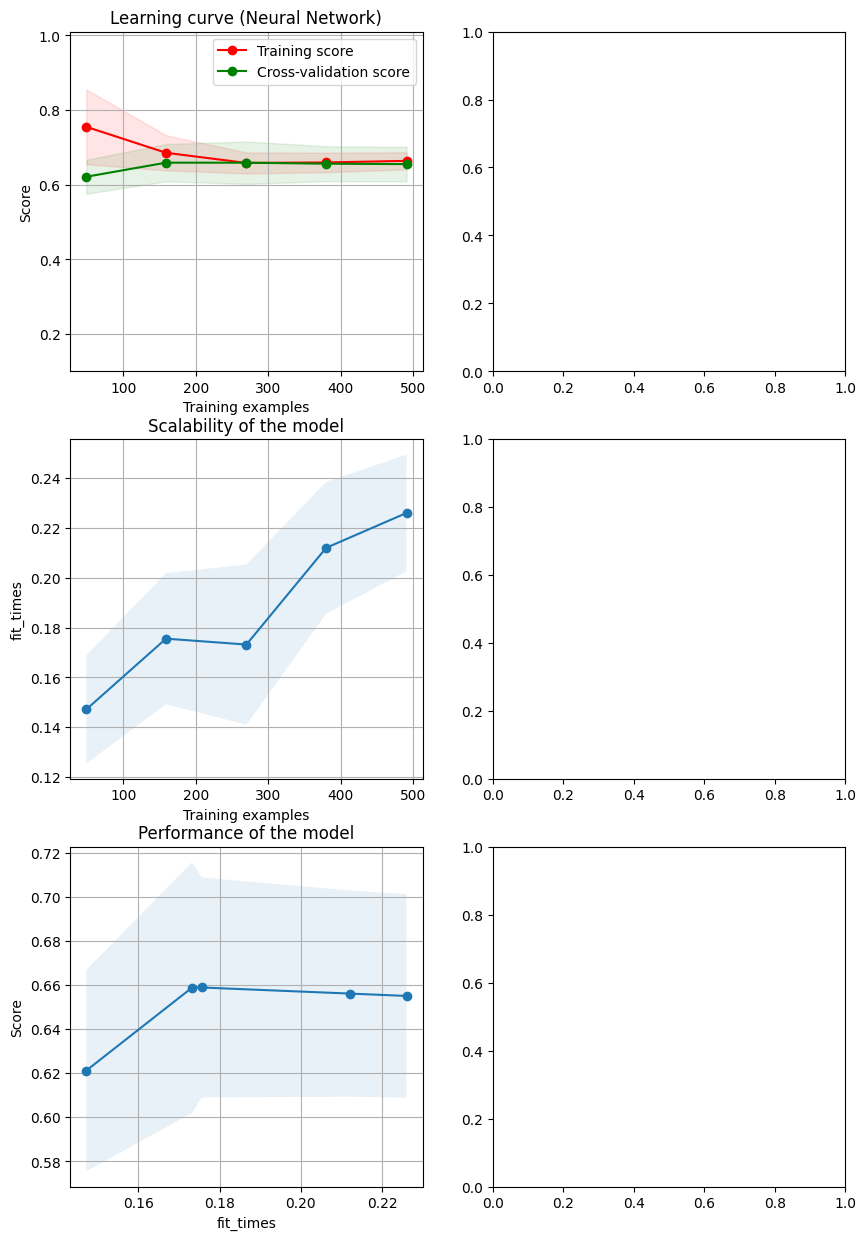

/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning curve (Neural Network)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = MLPClassifier(
    random_state=8451, 
    solver='lbfgs', 
    activation='identity', 
    learning_rate_init=learning_rate_init,
    hidden_layer_sizes=hidden_layer_sizes,
)

plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.1, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

# 4. KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

### Initial performance

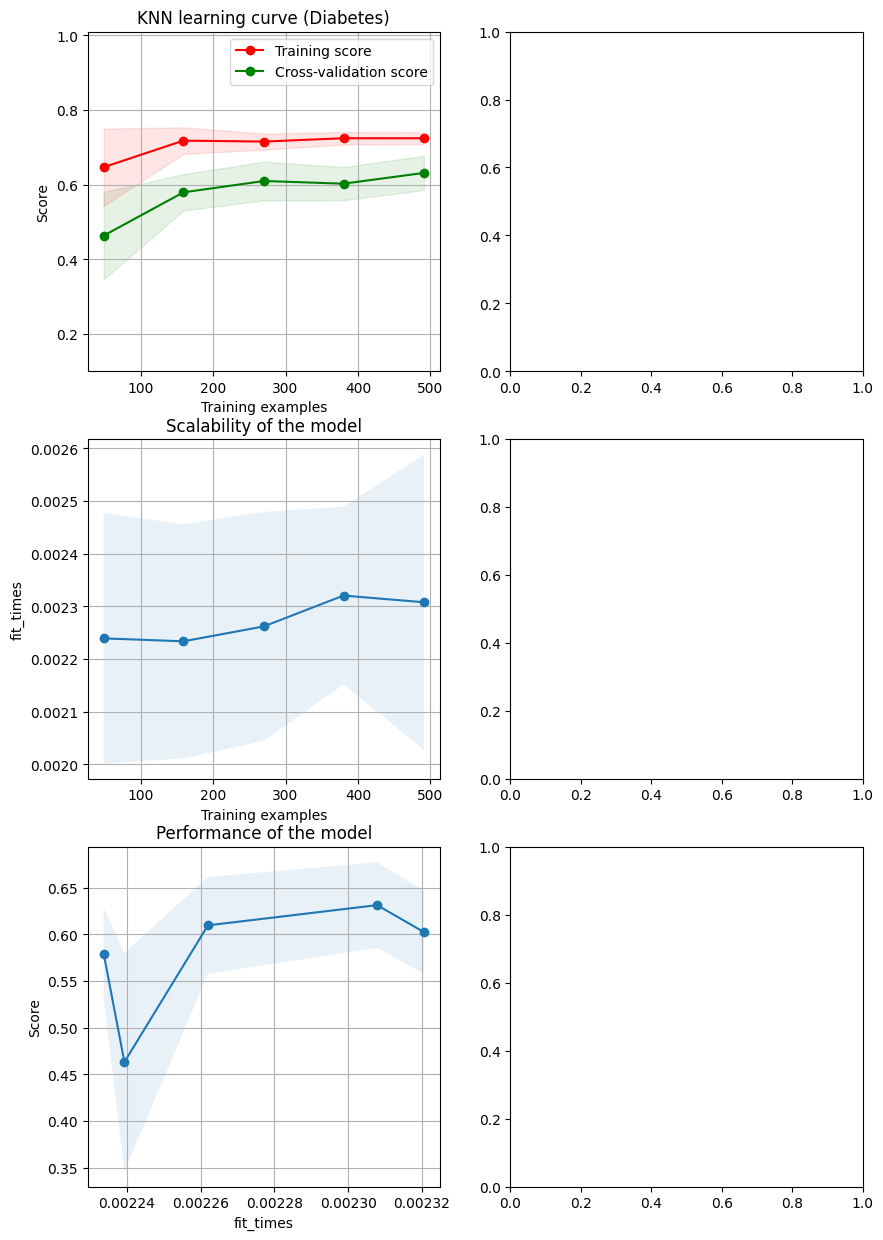

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "KNN learning curve (Diabetes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = KNeighborsClassifier()
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.1, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [50]:
# initial scoring

estimator = KNeighborsClassifier()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)
cv_results = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"], cv=cv)
print(f"Initial fit time is {cv_results['fit_time'].mean()}")
print(f"Initial score time is {cv_results['score_time'].mean()}")
print(f"Initial f1 score on cross validation {cv_results['test_f1'].mean()}")
print(f"Initial accuracy on cross validation {cv_results['test_accuracy'].mean() * 100}%")

Initial fit time is 0.0018478631973266602
Initial score time is 0.006777024269104004
Initial f1 score on cross validation 0.6314075390517332
Initial accuracy on cross validation 74.63414634146342%


In [51]:
# initial performance on test set
estimator = KNeighborsClassifier()

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.00297
Model Prediction Time (s): 0.00854
F1 Score:  0.485
Accuracy:  0.669


### Hyperparameter Tuning

In [52]:
%%time

# validation curves for max_depth for both gini and entropy criterion
n_neighbors = list(np.arange(3,25,2))

# accuracy scores
acc_n_neighbors = []

# f1 scores
f1_n_neighbors = []

for i in n_neighbors:
    estimator = KNeighborsClassifier(n_neighbors=i)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_n_neighbors.append(score["test_accuracy"].mean())
    f1_n_neighbors.append(score["test_f1"].mean())

knn_df = pd.DataFrame(
    {
        "acc_n_neighbors":pd.Series(acc_n_neighbors),      
        "f1_n_neighbors":pd.Series(f1_n_neighbors),
        "n_neighbors":pd.Series(n_neighbors),
    }
)


CPU times: user 481 ms, sys: 3.78 ms, total: 485 ms
Wall time: 484 ms


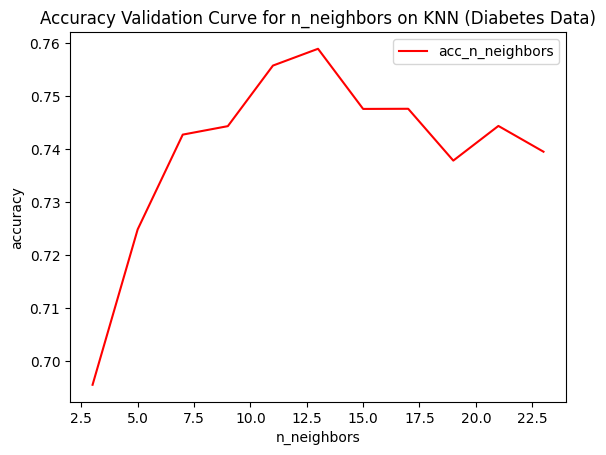

In [53]:
plt.plot("n_neighbors","acc_n_neighbors", color="r", data=knn_df)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for n_neighbors on KNN (Diabetes Data)")
plt.legend()

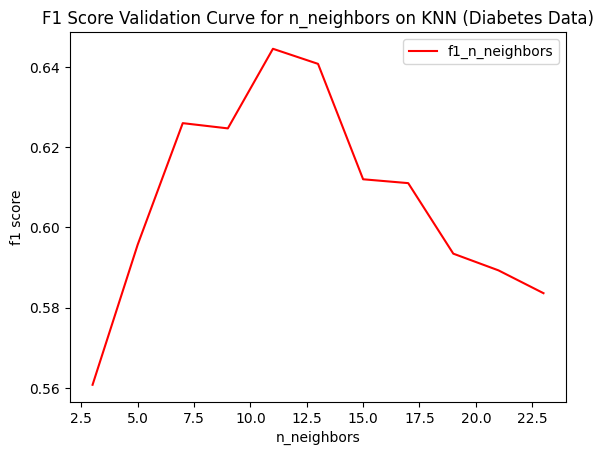

In [54]:
plt.plot("n_neighbors","f1_n_neighbors", color="r", data=knn_df)
plt.xlabel("n_neighbors")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for n_neighbors on KNN (Diabetes Data)")
plt.legend()

In [55]:
%%time

# Grid search
params = {'metric' : ['minkowski','euclidean'], 'n_neighbors':list(np.arange(1,30,1))}
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = estimator, param_grid=params, scoring="f1", cv=cv)
grid_search.fit(x_train, y_train)


metric = str(grid_search.best_params_["metric"])
n_neighbors = int(grid_search.best_params_["n_neighbors"])
print(f"Best metric from Hyperparameter tuning: {metric}")
print(f"Best n_neighbors from Hyperparameter tuning: {n_neighbors}")

Best metric from Hyperparameter tuning: minkowski
Best n_neighbors from Hyperparameter tuning: 11
CPU times: user 4.68 s, sys: 16.3 ms, total: 4.69 s
Wall time: 4.7 s


### Retrain with optimal parameters

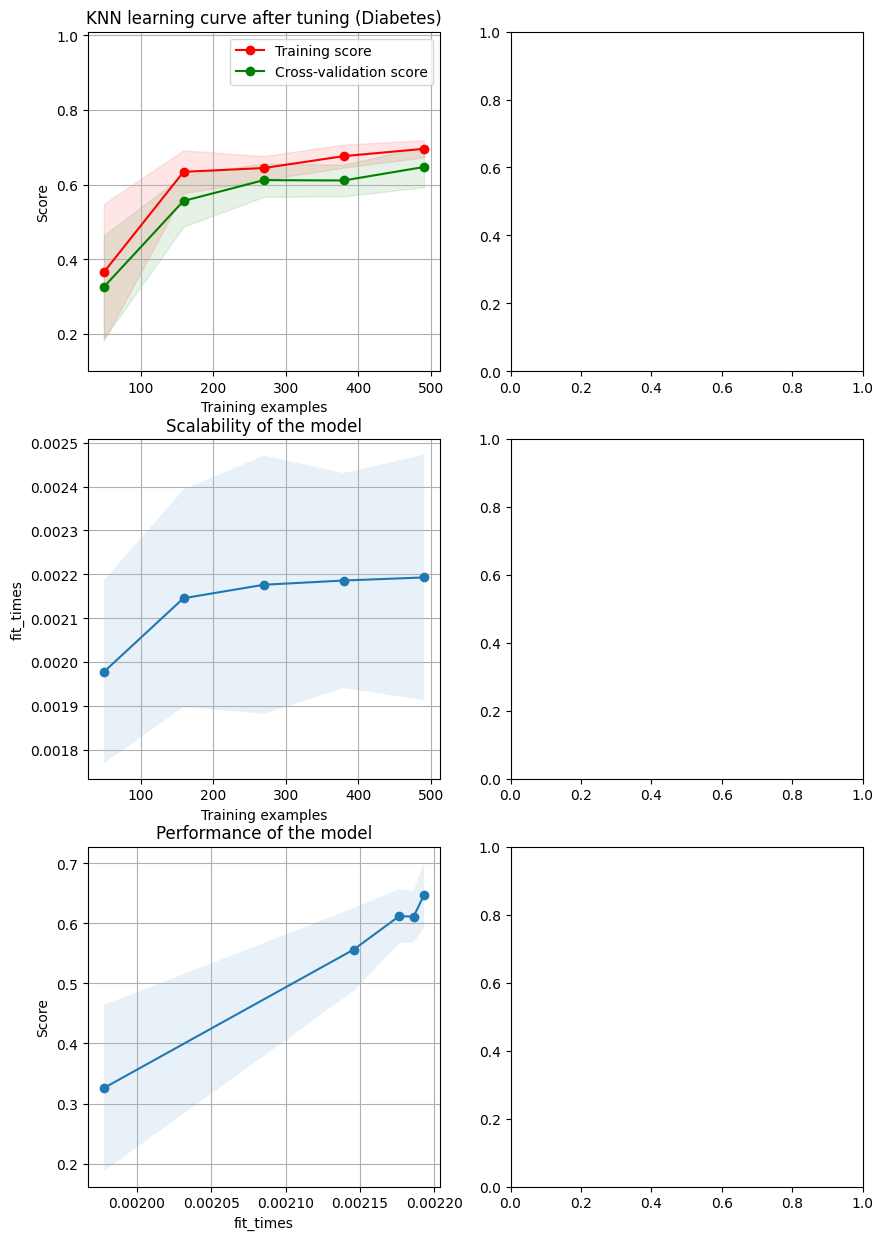

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "KNN learning curve after tuning (Diabetes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors)
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.1, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [57]:
estimator = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors)

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.00327
Model Prediction Time (s): 0.00784
F1 Score:  0.551
Accuracy:  0.714


# 5. SVM

Hyperparameters

    - Kernel
    - Gamma

In [58]:
from sklearn.svm import SVC

### Initial SVM with no tuning

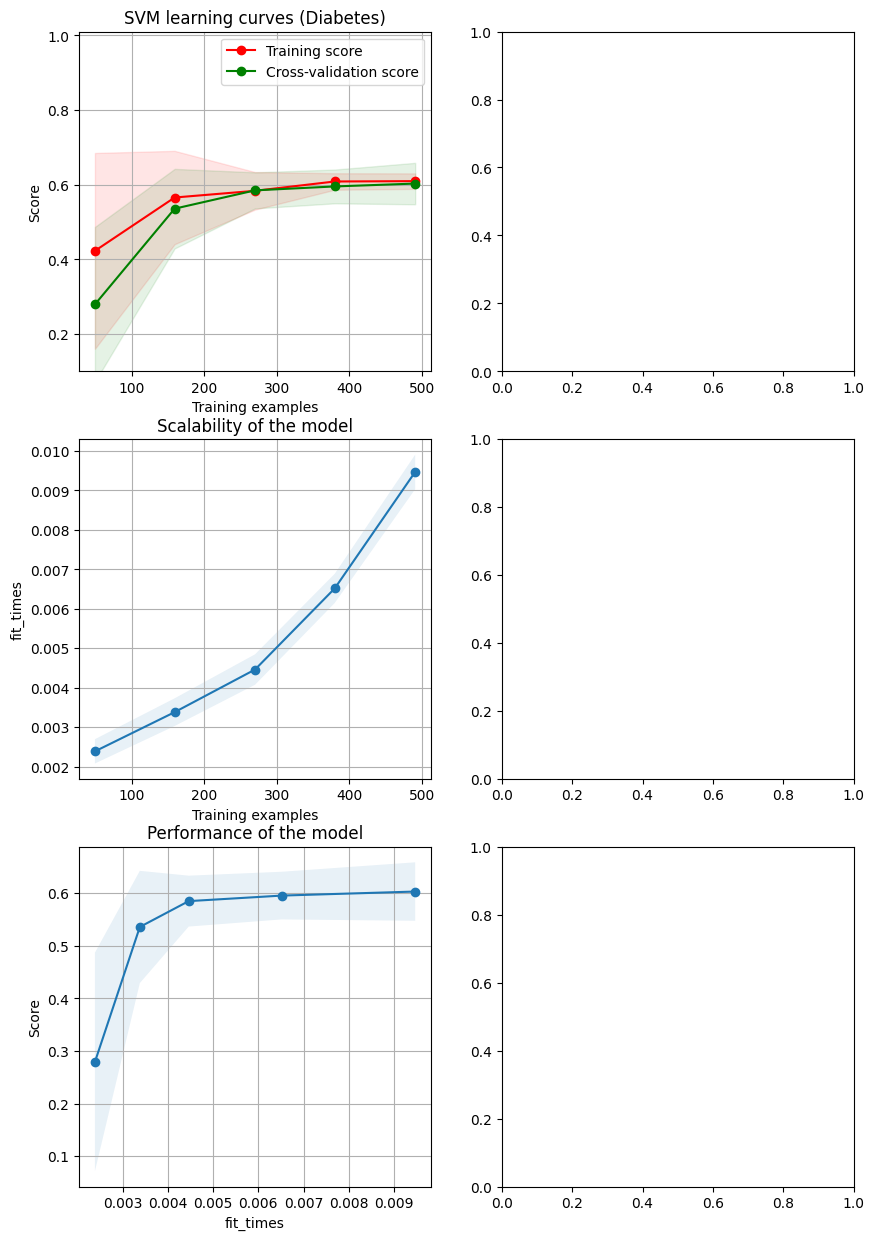

In [59]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "SVM learning curves (Diabetes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = SVC(random_state=8451)
plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.1, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [60]:
# initial scoring

estimator = SVC(random_state=8451)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)
cv_results = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"], cv=cv)
print(f"Initial fit time of boosting is {cv_results['fit_time'].mean()}")
print(f"Initial score time of boosting is {cv_results['score_time'].mean()}")
print(f"Initial f1 score of boosting on cross validation {cv_results['test_f1'].mean()}")
print(f"Initial accuracy of boosting on cross validation {cv_results['test_accuracy'].mean() * 100}%")

Initial fit time of boosting is 0.008629441261291504
Initial score time of boosting is 0.005743956565856934
Initial f1 score of boosting on cross validation 0.6028540262520563
Initial accuracy of boosting on cross validation 75.85365853658537%


In [61]:
# initial performance on test set
estimator = SVC(random_state=8451)
classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   0.01349
Model Prediction Time (s): 0.00705
F1 Score:  0.562
Accuracy:  0.747


### Hyperparameter Tuning

In [62]:
%%time

# validation curves for max_depth for both gini and entropy criterion
n_estimators = list(np.arange(5,100,5))
max_depth = [i for i in range(1,5)]
learning_rate = list(np.linspace(.1,2,20))

# accuracy scores
acc_kernel = []
acc_n_estimators = []
acc_learning_rate = []

# f1 scores
f1_kernel = []
f1_n_estimators = []
f1_learning_rate = []

kernel_functions = ['linear','rbf','sigmoid']
x = ['linear','rbf','sigmoid', 'poly_2','poly_3','poly_4','poly_5']

for i in kernel_functions:
    estimator = SVC(kernel=i, random_state=8451)
    score = cross_validate(estimator=estimator, X=x_train, y=y_train, scoring=["f1", "accuracy"])
    acc_kernel.append(score["test_accuracy"].mean())
    f1_kernel.append(score["test_f1"].mean())


for i in range(2,6):   
    estimator = SVC(kernel="poly", degree=i, random_state=8451)
    acc_kernel.append(score["test_accuracy"].mean())
    f1_kernel.append(score["test_f1"].mean())
    

kernel_df = pd.DataFrame(
    {
        "acc_kernel":pd.Series(acc_kernel),      
        "f1_kernel":pd.Series(f1_kernel),
        "kernel":pd.Series(x),
    }
)


CPU times: user 16.2 s, sys: 19 ms, total: 16.2 s
Wall time: 16.2 s


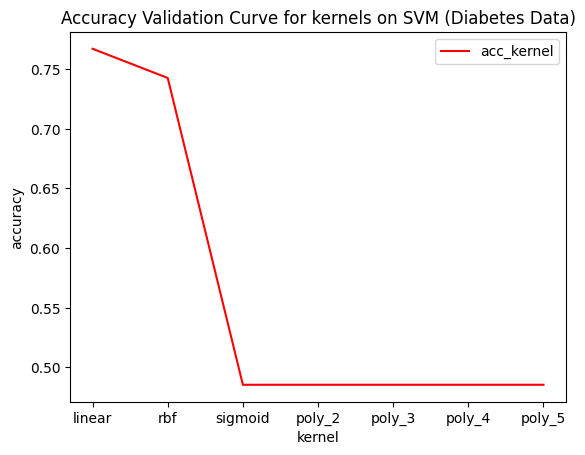

In [63]:
plt.plot("kernel","acc_kernel", color="r", data=kernel_df)
plt.xlabel("kernel")
plt.ylabel("accuracy")
plt.title("Accuracy Validation Curve for kernels on SVM (Diabetes Data)")
plt.legend()

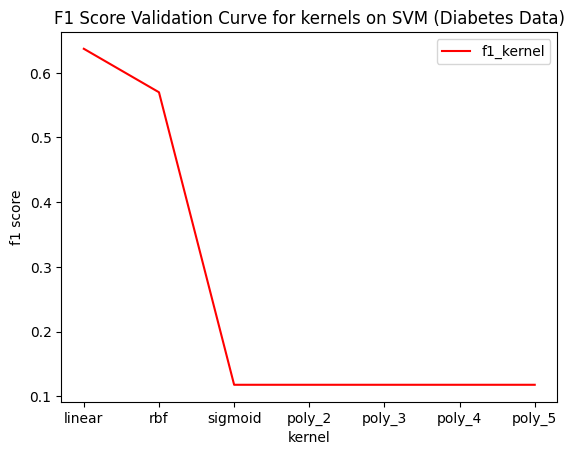

In [64]:
plt.plot("kernel","f1_kernel", color="r", data=kernel_df)
plt.xlabel("kernel")
plt.ylabel("f1 score")
plt.title("F1 Score Validation Curve for kernels on SVM (Diabetes Data)")
plt.legend()

In [65]:
%%time

# Grid search
gamma_range = [0.0001, 0.001, 0.1, 1]
C_range = [0.1, 1, 10]

params = {'gamma':gamma_range, "C":C_range}
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = SVC(random_state=8451, kernel="linear")
grid_search = GridSearchCV(estimator = estimator, param_grid=params, scoring="f1", cv=None)
grid_search.fit(x_train, y_train)

gamma = float(grid_search.best_params_["gamma"])
C = int(grid_search.best_params_["C"])
print(f"Best gamma from Hyperparameter tuning: {gamma}")
print(f"Best C from Hyperparameter tuning: {C}")
print(f"Best score from Hyperparameter tuning: {grid_search.best_score_}")

/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

Best gamma from Hyperparameter tuning: 0.0001
Best C from Hyperparameter tuning: 1
Best score from Hyperparameter tuning: 0.637071018864366
CPU times: user 10min 2s, sys: 531 ms, total: 10min 2s
Wall time: 10min 3s


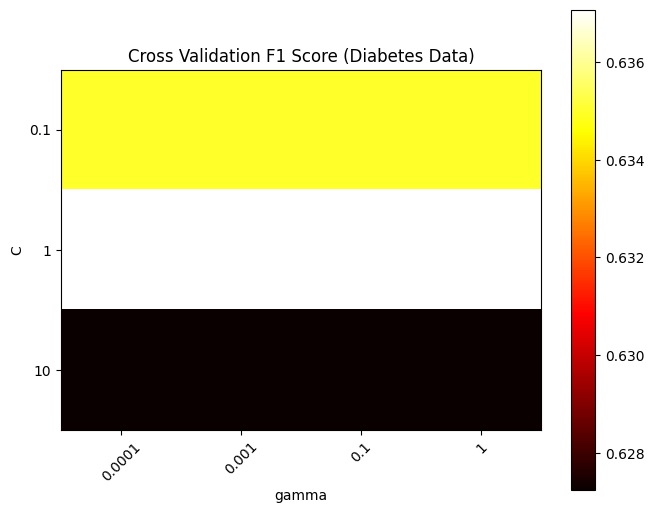

In [66]:
# Stolen from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# heat map for C and gamma

scores = grid_search.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
#     norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Cross Validation F1 Score (Diabetes Data)")
plt.show()

### Retrain with optimal parameters

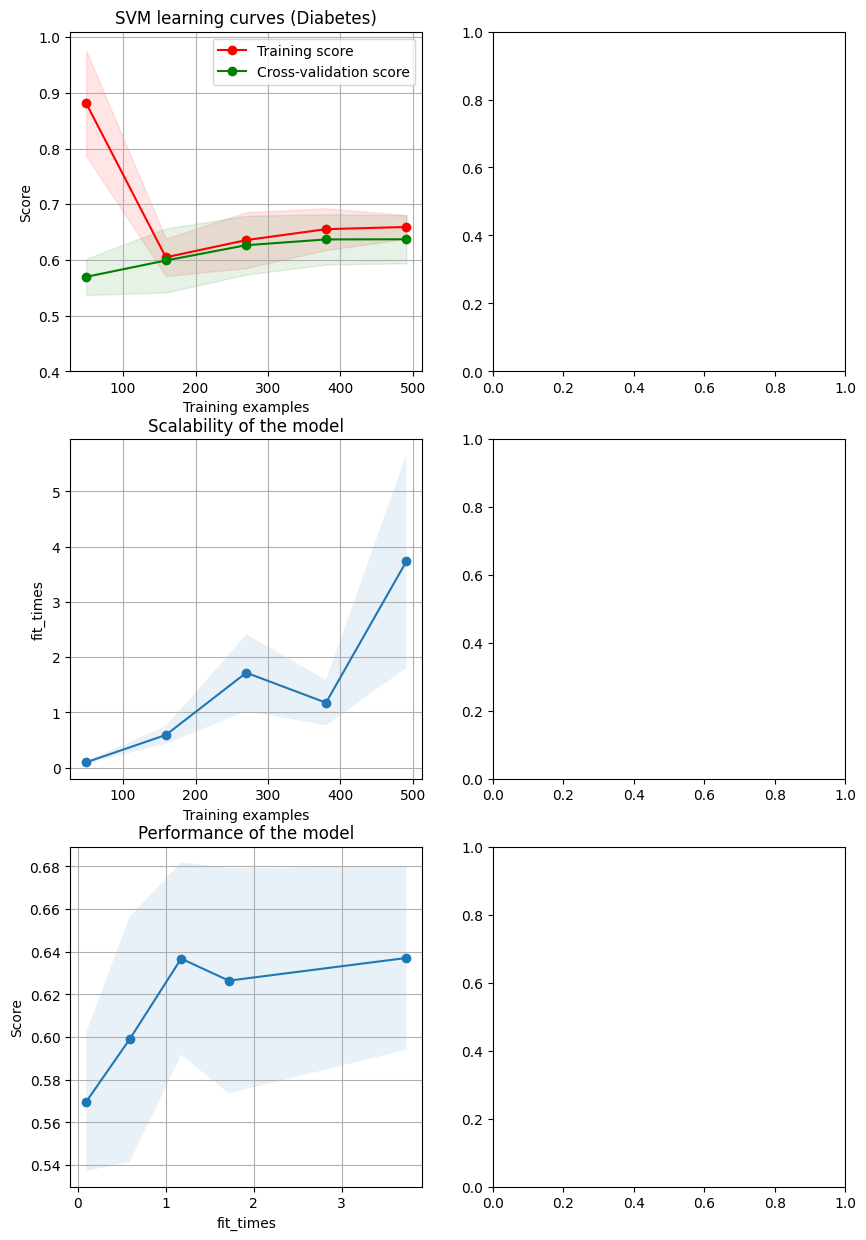

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "SVM learning curves (Diabetes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=8451)

estimator = SVC(
    random_state=8451,  
    gamma=gamma, 
    C=C,
    kernel="linear"
)

plot_learning_curve(
    estimator,
    title,
    x_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.4, 1.01),
    cv=None,
    n_jobs=4,
    scoring="f1",
)

plt.show()

In [80]:
estimator = SVC(
    random_state=8451,  
    gamma=gamma, 
    C=C,
    kernel="linear"
)

classifier_metrics(
    estimator=estimator,               
    x_train=x_train, 
    x_test=x_test, 
    y_train=y_train, 
    y_test=y_test
)

Metrics for Test Set
-------------------------------------------------------------
Model Training Time (s):   4.91041
Model Prediction Time (s): 0.00262
F1 Score:  0.600
Accuracy:  0.766
